In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [3]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect


In [5]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [6]:
# INSPECT

# Create inspector & connect to the engine
inspector = inspect(engine)

# Collect names of tables within the database
tables = inspector.get_table_names()

# print metadata for each table
for table in tables:
    print(table)
    print("-----------")
    
    # get columns
    columns = inspector.get_columns(table)
    for column in columns:
        print(column["name"], column["type"])

    print()

measurement
-----------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

station
-----------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT



In [7]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

# Print all classes mapped to the Base

print(list(Base.classes))

[<class 'sqlalchemy.ext.automap.measurement'>, <class 'sqlalchemy.ext.automap.station'>]


In [8]:
 # Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(Measurement.date)).first()
most_recent_date

('2017-08-23',)

Text(0, 0.5, 'Inches')

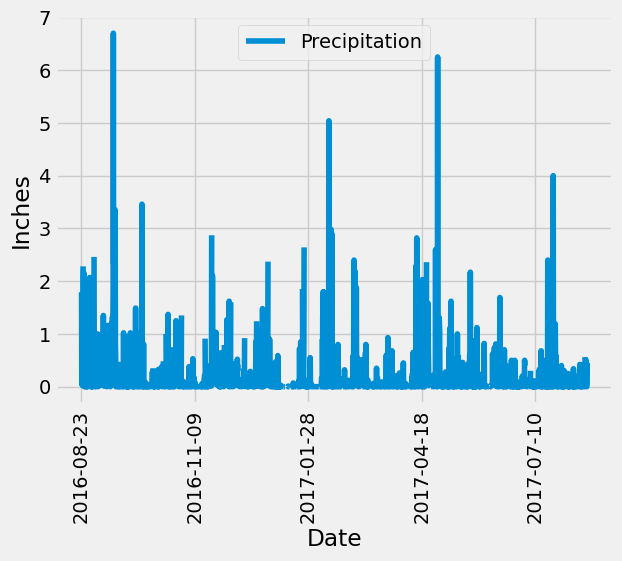

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
prev_year = dt.date(2017, 8, 23) - dt.timedelta(days=365)


# Perform a query to retrieve the data and precipitation scores
results = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= prev_year)

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df = pd.DataFrame(results, columns =['Date', 'Precipitation'])

# Sort the dataframe by date
df = df.sort_values("Date")

# Use Pandas Plotting with Matplotlib to plot the data
df.plot(x = 'Date', y = 'Precipitation', rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")

In [14]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number of stations in the dataset
num_of_stations = session.query(func.count(Station.station)).all()
num_of_stations

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
results = session.query(Measurement.station, func.count(Measurement.date)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(results, columns=["Station", "Observations"])
df2.head()

,Station,Observations
0,USC00519281,2772
1,USC00519397,2724
2,USC00513117,2709
3,USC00519523,2669
4,USC00516128,2612


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
results = session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.station == 'USC00519281').\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(results, columns=["min_temp", "avg_temp", "max_temp"])
df2.head()

,min_temp,avg_temp,max_temp
0,54.0,71.663781,85.0


In [20]:
# Calculate the date one year from the last date in data set.
start_date = dt.date(2016, 8, 23)

# Perform a query to retrieve the data and tobs scores
results = session.query(Measurement.date, Measurement.station, Measurement.tobs).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.date.asc()).\
    all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
df2 = pd.DataFrame(results, columns=["Date", "Station", "TOBS"])

# Sort the dataframe by date
df2["Date"] = pd.to_datetime(df2['Date'])
df2 = df2.sort_values(by="Date", ascending=True).reset_index(drop=True)

# Use Pandas Plotting with Matplotlib to plot the data
df2.head()

,Date,Station,TOBS
0,2016-08-23,USC00519281,77.0
1,2016-08-24,USC00519281,77.0
2,2016-08-25,USC00519281,80.0
3,2016-08-26,USC00519281,80.0
4,2016-08-27,USC00519281,75.0


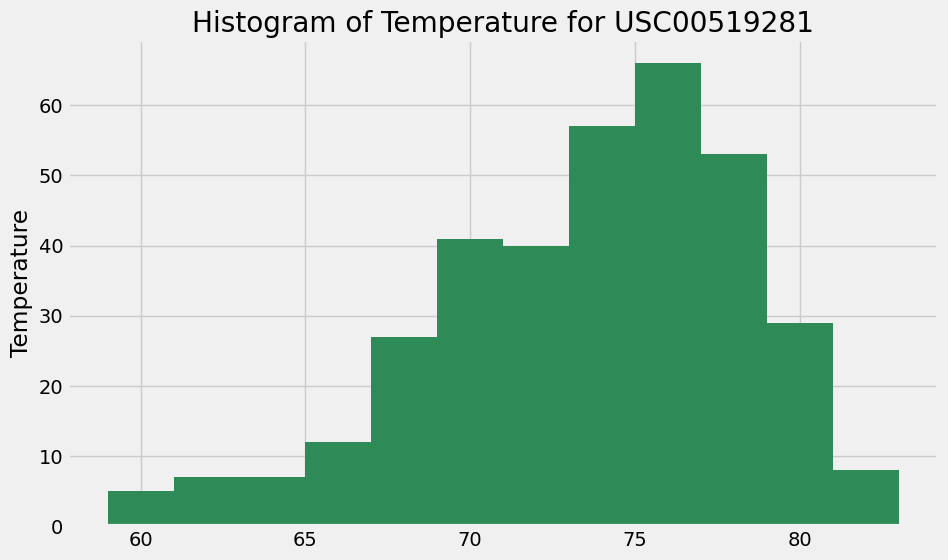

In [23]:
plt.figure(figsize=(10,6))
plt.hist(df2.TOBS, color="seagreen", bins=12)
plt.ylabel("Frequency")
plt.ylabel("Temperature")
plt.title("Histogram of Temperature for USC00519281")
plt.show()

# Close Session

In [24]:
# Close Session
session.close()
